In [2]:
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import ADASYN
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.metrics import recall_score

In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
glioma_grading_clinical_and_mutation_features = fetch_ucirepo(id=759) 
  
# data (as pandas dataframes) 
X = glioma_grading_clinical_and_mutation_features.data.features 
y = glioma_grading_clinical_and_mutation_features.data.targets 

In [4]:
def categorise_age(age):
    if age <= 19:
        return "Paediatric"
    elif 20 <= age <= 39:
        return "Young Adult"
    elif 40 <= age <= 64:
        return "Adult"
    else:
        return "Elderly"

X['Age_class_at_diagnosis'] = X['Age_at_diagnosis'].apply(categorise_age)

/var/folders/hf/3rv_98fd6y5b8tx745n5n1s00000gn/T/ipykernel_4907/2568762353.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Age_class_at_diagnosis'] = X['Age_at_diagnosis'].apply(categorise_age)


In [5]:
gender_mapping = {0 : 'Male', 1 : 'Female'}

X['Gender'] = X['Gender'].map(gender_mapping)

/var/folders/hf/3rv_98fd6y5b8tx745n5n1s00000gn/T/ipykernel_4907/1515168427.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Gender'] = X['Gender'].map(gender_mapping)


In [6]:
X['demographic'] = X['Gender'] + ', ' + X['Race'] + ', ' + X['Age_class_at_diagnosis']
X.drop(columns = ["Age_class_at_diagnosis", "Gender", "Race", "Age_at_diagnosis"], inplace = True)

In [7]:
demo_mapping = {
 'male, white, paediatric': 1,
 'male, black or african american, paediatric': 2,
 'male, asian, paediatric': 3,
 'male, american indian or alaska native, paediatric': 4,
 'male, white, young adult': 5,
 'male, black or african american, young adult': 6,
 'male, asian, young adult': 7,
 'male, american indian or alaska native, young adult': 8,
 'male, white, adult': 9,
 'male, black or african american, adult': 10,
 'male, asian, adult': 11,
 'male, american indian or alaska native, adult': 12,
 'male, white, elderly': 13,
 'male, black or african american, elderly': 14,
 'male, asian, elderly': 15,
 'male, american indian or alaska native, elderly': 16,
 'female, white, paediatric': 17,
 'female, black or african american, paediatric': 18,
 'female, asian, paediatric': 19,
 'female, american indian or alaska native, paediatric': 20,
 'female, white, young adult': 21,
 'female, black or african american, young adult': 22,
 'female, asian, young adult': 23,
 'female, american indian or alaska native, young adult': 24,
 'female, white, adult': 25,
 'female, black or african american, adult': 26,
 'female, asian, adult': 27,
 'female, american indian or alaska native, adult': 28,
 'female, white, elderly': 29,
 'female, black or african american, elderly': 30,
 'female, asian, elderly': 31,
 'female, american indian or alaska native, elderly': 32
}



X['demographic'] = X['demographic'].str.lower().map(demo_mapping)

## Removing the White population from the training set for feature selection

In [9]:
X_no_white = X[~X['demographic'].isin([1, 5, 9, 13, 17, 21, 25, 29])]
y_no_white = y[y.index.isin(X_no_white.index)]

## Splitting the data for feature selection

In [11]:
## Splitting the dataset 25:75
X_train_no_white, X_test_no_white, y_train_no_white, y_test_no_white = train_test_split(X_no_white, y_no_white, test_size = 0.1, random_state = 1)
X_train_no_white, X_val_no_white, y_train_no_white, y_val_no_white = train_test_split(X_train_no_white, y_train_no_white, test_size = 0.25, random_state = 1)



y_test_no_white = y_test_no_white.values.ravel()
y_train_no_white = y_train_no_white.values.ravel()

## Feature selection

In [13]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

def mrmr_feature_selection(X, y, n_features, random_state=1):
    """Performs mRMR feature selection."""
    np.random.seed(random_state)  # Set random state
    y = y.ravel()  # Ensure y is a 1D array

    mi = mutual_info_classif(X, y, random_state=random_state)  # Compute mutual information
    selected_features = []
    remaining_features = list(range(X.shape[1]))

    # Select the most relevant feature first
    first_feature = np.argmax(mi)
    selected_features.append(first_feature)
    remaining_features.remove(first_feature)

    # Iteratively select remaining features
    for _ in range(min(n_features - 1, len(remaining_features))):
        relevance = mi[remaining_features]

        # Compute redundancy safely
        redundancy_values = []
        for sel in selected_features:
            for f in remaining_features:
                corr = np.corrcoef(
                    X.iloc[:, f] if isinstance(X, pd.DataFrame) else X[:, f],
                    X.iloc[:, sel] if isinstance(X, pd.DataFrame) else X[:, sel]
                )[0, 1]
                redundancy_values.append(corr)

        redundancy = np.nanmean(redundancy_values) if redundancy_values else 0  # Avoid NaN issues
        score = relevance - redundancy  # Compute mRMR score

        if len(score) == 0:
            break  # Prevent empty sequence error

        next_feature = remaining_features[np.argmax(score)]
        selected_features.append(next_feature)
        remaining_features.remove(next_feature)

    return selected_features

def embedded_lasso_selection(X, y, random_state=1):
    """Performs feature selection using LASSO regression."""
    np.random.seed(random_state)  # Set random state
    y = y.ravel()  # Ensure y is a 1D array
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    lasso = LassoCV(cv=5, max_iter=10000, random_state=random_state)
    lasso.fit(X_scaled, y)

    selected_features = np.where(lasso.coef_ != 0)[0]
    return selected_features

def mrmr_lasso_pipeline(X, y, top_n_mrmr=20, random_state=1):
    """Pipeline combining mRMR and embedded LASSO feature selection."""
    np.random.seed(random_state)  # Set random state
    y = y.values.ravel()  # Ensure y is 1D
    selected_mrmr = mrmr_feature_selection(X, y, top_n_mrmr, random_state=random_state)
    
    # Ensure indexing works for both Pandas and NumPy
    X_mrmr = X.iloc[:, selected_mrmr] if isinstance(X, pd.DataFrame) else X[:, selected_mrmr]

    selected_lasso = embedded_lasso_selection(X_mrmr, y, random_state=random_state)
    final_features = [selected_mrmr[i] for i in selected_lasso]

    return final_features

In [14]:
def mrmr_lasso_pipeline(X, y, desired_n_features=13, buffer_mrmr=30, random_state=1):
    """
    Selects exactly `desired_n_features` using mRMR followed by LASSO.
    `buffer_mrmr` should be greater than `desired_n_features` to give LASSO enough features to choose from.
    """
    np.random.seed(random_state)
    y = y.values.ravel() if hasattr(y, 'values') else y.ravel()
    
    # Step 1: Run mRMR with more than desired features
    selected_mrmr = mrmr_feature_selection(X, y, buffer_mrmr, random_state=random_state)
    X_mrmr = X.iloc[:, selected_mrmr] if isinstance(X, pd.DataFrame) else X[:, selected_mrmr]

    # Step 2: Run LASSO to refine
    selected_lasso = embedded_lasso_selection(X_mrmr, y, random_state=random_state)

    # Step 3: Map back to original feature indices
    final_features = [selected_mrmr[i] for i in selected_lasso]

    # Step 4: Ensure we return exactly desired_n_features
    if len(final_features) < desired_n_features:
        # Fill remaining features based on mRMR ranking not yet selected
        for feat in selected_mrmr:
            if feat not in final_features:
                final_features.append(feat)
            if len(final_features) == desired_n_features:
                break
    else:
        final_features = final_features[:desired_n_features]

    return final_features


In [15]:
final_selected_features = mrmr_lasso_pipeline(X_train_no_white, y_train_no_white, random_state = 1)

print("Selected Feature Indices:", final_selected_features)

/Users/mollydonaghey/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/mollydonaghey/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Selected Feature Indices: [0, 3, 1, 10, 2, 7, 8, 11, 17, 20, 5, 12, 6]


## Splitting for model training and testing

In [17]:
## Splitting the dataset 25:75
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = 1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 1)


y_test = y_test.values.ravel()
y_train = y_train.values.ravel()

In [18]:
X_train = X_train.iloc[:, [0, 3, 1, 10, 2, 7, 8, 11, 17, 20, 5, 12, 6]]

In [20]:
import xgboost as xgb
model = xgb.XGBClassifier(eval_metric='error')

In [21]:
# Define the parameter grid
param_grid = {
    'n_estimators': [20, 50, 100, 200],
    'max_depth': [2, 3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=10,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_val, y_val)

# Output best params and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 10 folds for each of 432 candidates, totalling 4320 fits
Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Best Score: 0.8701582387340903


In [22]:
model = xgb.XGBClassifier(eval_metric='error', colsample_bytree = 0.6, learning_rate = 0.01, max_depth = 3, n_estimators = 200, subsample = 1.0)
model.fit(X_train, y_train)

# Make predictions
X_test = X_test.iloc[:, [0, 3, 1, 10, 2, 7, 8, 11, 17, 20, 5, 12, 6]]
prediction = model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, prediction)
print(f"Accuracy: {accuracy:.2f}")

sensitivity = recall_score(y_test, prediction)
print(f"Sensitivity: {sensitivity:.2f}")


Accuracy: 0.77
Sensitivity: 0.77


In [23]:
results_df = pd.DataFrame({
    'demographic': X_test['demographic'],
    'actual': y_test,
    'predicted': prediction
})

# Compute accuracy per demographic
accuracy_per_demo_norm = results_df.groupby('demographic').apply(
    lambda x: accuracy_score(x['actual'], x['predicted'])
).reset_index()

sensitivity_per_demo_norm = results_df.groupby('demographic').apply(
    lambda x: recall_score(x['actual'], x['predicted'])
).reset_index()

/Users/mollydonaghey/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mollydonaghey/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mollydonaghey/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
accuracy_per_demo_norm.columns = ['demographic', 'accuracy_norm']
sensitivity_per_demo_norm.columns = ['demographic', 'sensitivity_norm']

## SMOTE and XGBoost

In [26]:
## Splitting the dataset 25:75
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = 1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 1)


y_test = y_test.values.ravel()
y_train = y_train.values.ravel()

In [27]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Assign y to X before balancing
X_train['Grading'] = y_train

# Define the minimum required samples per demographic group
min_samples = 2

# Ensure that each demographic has at least `min_samples` samples
X_train_balanced = X_train.groupby('demographic', group_keys=False).apply(
    lambda x: x if len(x) >= min_samples else x.sample(min_samples, replace=True)
)

# Extract demographic column
demographic = X_train_balanced['demographic']

# Extract features (excluding demographic and Grading)
mutations_grading = X_train_balanced.drop(columns=['demographic'])

# Extract the balanced target variable
y_train_balanced = X_train_balanced['Grading']

In [28]:
smote = SMOTE(k_neighbors=1, random_state=1, sampling_strategy='minority')
mutations_grading_resampled, demographic_resampled = smote.fit_resample(mutations_grading, demographic)

In [38]:
df_train_resampled = mutations_grading_resampled
df_train_resampled['demographic'] = demographic_resampled

In [42]:
y_train_resampled = df_train_resampled['Grading']
X_train_resampled = df_train_resampled.drop(columns = 'Grading')

### XGBoost

In [45]:
df_train_resampled_no_white = df_train_resampled[~ df_train_resampled['demographic'].isin([1,5,9,13,17,21,25,29])]
y_train_resampled_no_white = df_train_resampled_no_white['Grading']
X_train_resampled_no_white = df_train_resampled_no_white.drop(columns = 'Grading')

In [46]:
final_selected_features = mrmr_lasso_pipeline(X_train_resampled_no_white, y_train_resampled_no_white, random_state = 1)

print("Selected Feature Indices:", final_selected_features)

Selected Feature Indices: [12, 6, 0, 15, 20, 3, 5, 9, 1, 2, 13, 17, 10]


/Users/mollydonaghey/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/mollydonaghey/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/var/folders/hf/3rv_98fd6y5b8tx745n5n1s00000gn/T/ipykernel_4907/3042580012.py:33: RuntimeWarning: Mean of empty slice
  redundancy = np.nanmean(redundancy_values) if redundancy_values else 0  # Avoid NaN issues


In [47]:
## Splitting the dataset 10:90
X_train_resampled = X_train_resampled.iloc[:, [12, 6, 0, 15, 20, 3, 5, 9, 1, 2, 13, 17, 10]]

In [48]:
model = xgb.XGBClassifier(eval_metric='error')

In [49]:
# Define the parameter grid
param_grid = {
    'n_estimators': [20, 50, 100, 200],
    'max_depth': [2, 3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_val, y_val)

# Output best params and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 20, 'subsample': 1.0}
Best Score: 0.862432416013608


In [50]:
model = xgb.XGBClassifier(eval_metric='error', colsample_bytree = 0.8, learning_rate = 0.1, max_depth = 3, n_estimators = 20, subsample = 1.0)

model.fit(X_train_resampled, y_train_resampled)

# Make predictions
X_test = X_test.iloc[:, [12, 6, 0, 15, 20, 3, 5, 9, 1, 2, 13, 17, 10]]
prediction = model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, prediction)
print(f"Accuracy: {accuracy:.2f}")

sensitivity = recall_score(y_test, prediction)
print(f"Sensitivity: {sensitivity:.2f}")

Accuracy: 0.79
Sensitivity: 0.79


In [51]:
results_SMOTE_df = pd.DataFrame({
    'demographic': X_test['demographic'],
    'actual': y_test,
    'predicted': prediction
})

# Compute accuracy per demographic
accuracy_per_demo_SMOTE = results_SMOTE_df.groupby('demographic').apply(
    lambda x: accuracy_score(x['actual'], x['predicted'])
)

sensitivity_per_demo_SMOTE = results_SMOTE_df.groupby('demographic').apply(
    lambda x: recall_score(x['actual'], x['predicted'])
)

/Users/mollydonaghey/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mollydonaghey/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mollydonaghey/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
accuracy_per_demo_SMOTE = pd.DataFrame(accuracy_per_demo_SMOTE)
accuracy_per_demo_SMOTE.reset_index(inplace = True)
accuracy_per_demo_SMOTE.columns = ['demographic', 'accuracy_SMOTE']

## Accuracy and Sensitivity

In [54]:
accuracy_per_demo = accuracy_per_demo_SMOTE.merge(accuracy_per_demo_norm, on = 'demographic', how = 'left')

In [55]:
swapped_demo_mapping = {
    1: 'male, white, paediatric',
    2: 'male, black or african american, paediatric',
    3: 'male, asian, paediatric',
    4: 'male, american indian or alaska native, paediatric',
    5: 'male, white, young adult',
    6: 'male, black or african american, young adult',
    7: 'male, asian, young adult',
    8: 'male, american indian or alaska native, young adult',
    9: 'male, white, adult',
    10: 'male, black or african american, adult',
    11: 'male, asian, adult',
    12: 'male, american indian or alaska native, adult',
    13: 'male, white, elderly',
    14: 'male, black or african american, elderly',
    15: 'male, asian, elderly',
    16: 'male, american indian or alaska native, elderly',
    17: 'female, white, paediatric',
    18: 'female, black or african american, paediatric',
    19: 'female, asian, paediatric',
    20: 'female, american indian or alaska native, paediatric',
    21: 'female, white, young adult',
    22: 'female, black or african american, young adult',
    23: 'female, asian, young adult',
    24: 'female, american indian or alaska native, young adult',
    25: 'female, white, adult',
    26: 'female, black or african american, adult',
    27: 'female, asian, adult',
    28: 'female, american indian or alaska native, adult',
    29: 'female, white, elderly',
    30: 'female, black or african american, elderly',
    31: 'female, asian, elderly',
    32: 'female, american indian or alaska native, elderly'
}

accuracy_per_demo['demographic_names'] = accuracy_per_demo['demographic'].map(swapped_demo_mapping)

In [56]:
accuracy_per_demo

,demographic,accuracy_SMOTE,accuracy_norm,demographic_names
0,5,1.000000,1.000000,"male, white, young adult"
1,9,0.809524,0.809524,"male, white, adult"
2,10,1.000000,1.000000,"male, black or african american, adult"
3,13,0.692308,0.692308,"male, white, elderly"
4,14,0.666667,0.666667,"male, black or african american, elderly"
5,21,0.800000,0.800000,"female, white, young adult"
6,22,1.000000,1.000000,"female, black or african american, young adult"
7,25,0.722222,0.666667,"female, white, adult"
8,26,0.000000,0.000000,"female, black or african american, adult"
9,29,1.000000,1.000000,"female, white, elderly"


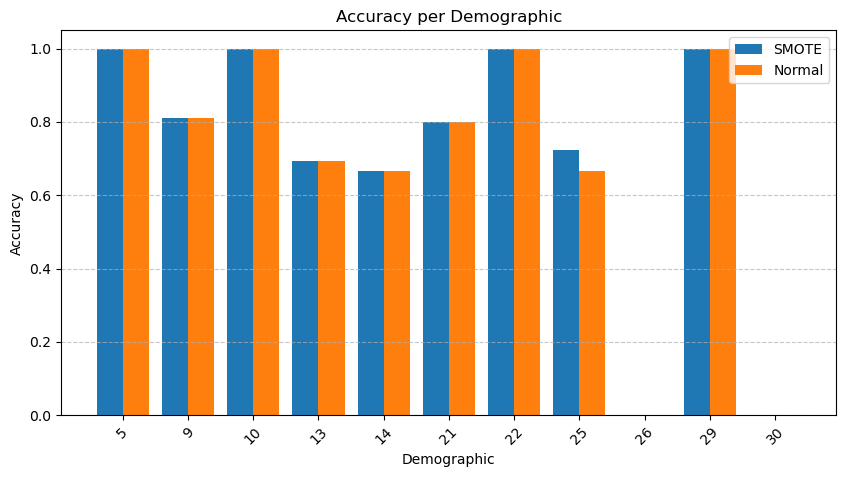

In [57]:
x = np.arange(len(accuracy_per_demo['demographic']))  # Numeric positions for categories
width = 0.4

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, accuracy_per_demo['accuracy_SMOTE'], width, label='SMOTE')
plt.bar(x + width/2, accuracy_per_demo['accuracy_norm'], width, label='Normal')

plt.xlabel('Demographic')
plt.ylabel('Accuracy')
plt.title('Accuracy per Demographic')
plt.xticks(ticks=x, labels=accuracy_per_demo['demographic'], rotation=45)  
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7) 

plt.show()

In [58]:
sensitivity_per_demo_SMOTE = sensitivity_per_demo_SMOTE.reset_index()

In [59]:
sensitivity_per_demo_SMOTE = pd.DataFrame(sensitivity_per_demo_SMOTE)
sensitivity_per_demo_SMOTE.columns = ['demographic', 'sensitivity_SMOTE']


sensitivity_per_demo = sensitivity_per_demo_SMOTE.merge(sensitivity_per_demo_norm, on = 'demographic', how = 'left')
sensitivity_per_demo['demographic names'] = sensitivity_per_demo['demographic'].map(swapped_demo_mapping)
sensitivity_per_demo

,demographic,sensitivity_SMOTE,sensitivity_norm,demographic names
0,5,0.000000,0.000000,"male, white, young adult"
1,9,0.928571,0.928571,"male, white, adult"
2,10,1.000000,1.000000,"male, black or african american, adult"
3,13,0.777778,0.777778,"male, white, elderly"
4,14,0.666667,0.666667,"male, black or african american, elderly"
5,21,0.000000,0.000000,"female, white, young adult"
6,22,1.000000,1.000000,"female, black or african american, young adult"
7,25,0.571429,0.428571,"female, white, adult"
8,26,0.000000,0.000000,"female, black or african american, adult"
9,29,1.000000,1.000000,"female, white, elderly"


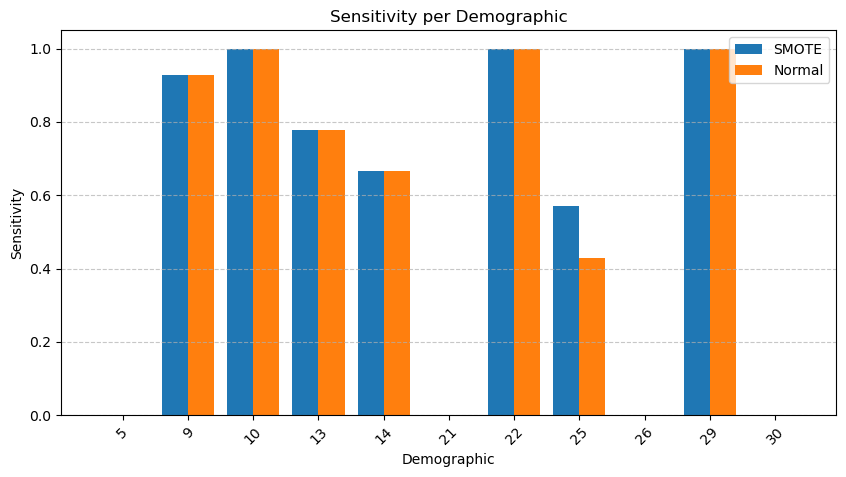

In [60]:
x = np.arange(len(sensitivity_per_demo['demographic']))  # Numeric positions for categories
width = 0.4

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, sensitivity_per_demo['sensitivity_SMOTE'], width, label='SMOTE')
plt.bar(x + width/2, sensitivity_per_demo['sensitivity_norm'], width, label='Normal')

plt.xlabel('Demographic')
plt.ylabel('Sensitivity')
plt.title('Sensitivity per Demographic')
plt.xticks(ticks=x, labels=sensitivity_per_demo['demographic'], rotation=45)  # Properly label x-axis
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a horizontal grid for better readability

plt.show()

### ROC curve

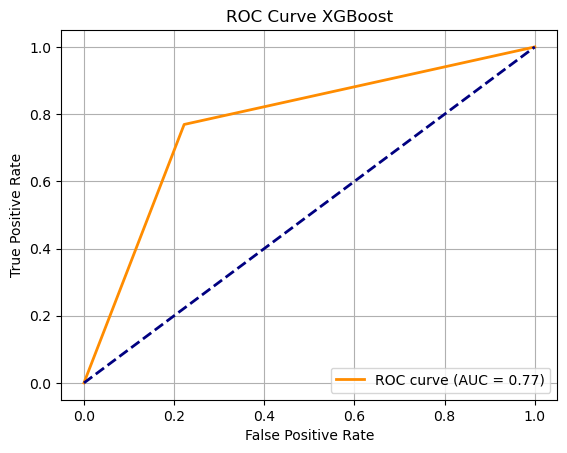

In [62]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(results_df['actual'], results_df['predicted'])

# Compute AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve XGBoost')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [63]:
from sklearn.metrics import roc_curve, auc

# Create an empty dictionary to hold the AUC for each demographic
auc_per_demo = {}

# Group by demographic and compute AUC for each group
for demo, group in results_df.groupby('demographic'):
    fpr, tpr, _ = roc_curve(group['actual'], group['predicted'])
    auc_score = auc(fpr, tpr)
    auc_per_demo[demo] = auc_score

# Optional: convert to a DataFrame
auc_per_demo_df = pd.DataFrame.from_dict(auc_per_demo, orient='index', columns=['AUC'])
auc_per_demo_df

/Users/mollydonaghey/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/mollydonaghey/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/Users/mollydonaghey/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/Users/mollydonaghey/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/mollydonaghey/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, fa

,AUC
5,NaN
9,0.750000
10,NaN
13,0.638889
14,NaN
21,0.444444
22,1.000000
25,0.623377
26,NaN
29,NaN


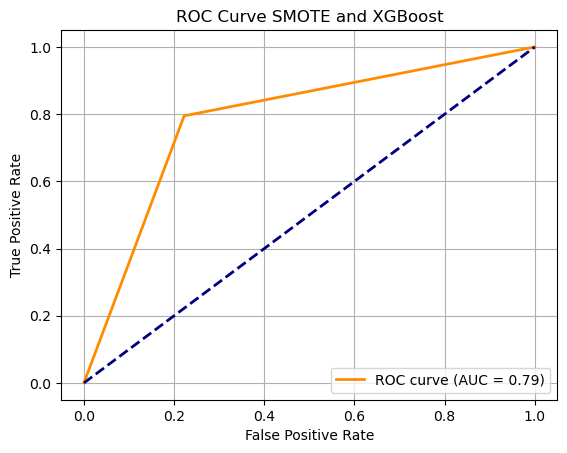

In [64]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(results_SMOTE_df['actual'], results_SMOTE_df['predicted'])

# Compute AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve SMOTE and XGBoost')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [65]:
from sklearn.metrics import roc_curve, auc

# Create an empty dictionary to hold the AUC for each demographic
auc_per_demo_SMOTE = {}

# Group by demographic and compute AUC for each group
for demo, group in results_SMOTE_df.groupby('demographic'):
    fpr, tpr, _ = roc_curve(group['actual'], group['predicted'])
    auc_score = auc(fpr, tpr)
    auc_per_demo_SMOTE[demo] = auc_score

# Optional: convert to a DataFrame
auc_per_demo_SMOTE_df = pd.DataFrame.from_dict(auc_per_demo_SMOTE, orient='index', columns=['AUC'])
auc_per_demo_SMOTE_df

/Users/mollydonaghey/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/mollydonaghey/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/Users/mollydonaghey/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/Users/mollydonaghey/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/mollydonaghey/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, fa

,AUC
5,NaN
9,0.750000
10,NaN
13,0.638889
14,NaN
21,0.444444
22,1.000000
25,0.694805
26,NaN
29,NaN
